**Import Libraries**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


**Generate Dummy Data**

In [13]:
np.random.seed(42)
n_samples = 5000

data = pd.DataFrame({
    'Customer_ID': range(1, n_samples + 1),
    'Age': np.random.randint(21, 70, n_samples),
    'Gender': np.random.choice(['Male', 'Female'], n_samples),
    'Income': np.random.randint(20000, 150000, n_samples),
    'Credit_Score': np.random.randint(300, 850, n_samples),
    'Loan_Amount': np.random.randint(1000, 50000, n_samples),
    'Loan_Term': np.random.choice([12, 24, 36, 48, 60], n_samples),
    'Employment_Status': np.random.choice(['Employed', 'Self-employed', 'Unemployed'], n_samples),
    'Previous_Default': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
    'Num_Credit_Cards': np.random.randint(0, 10, n_samples),
})

# Debt to Income ratio
data['Debt_to_Income'] = (data['Loan_Amount'] / data['Income']).round(2)

# Target variable: Default
prob_default = (
    0.3*(data['Credit_Score'] < 600) +
    0.3*(data['Debt_to_Income'] > 0.4) +
    0.4*data['Previous_Default']
)
data['Default'] = np.random.binomial(1, prob_default)

**Exploratory Data Analysis (EDA)**

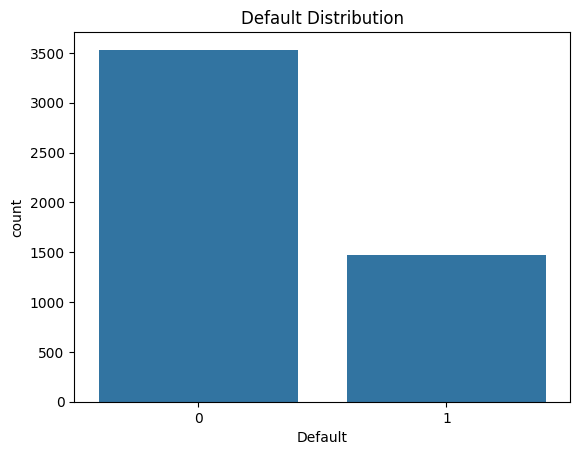

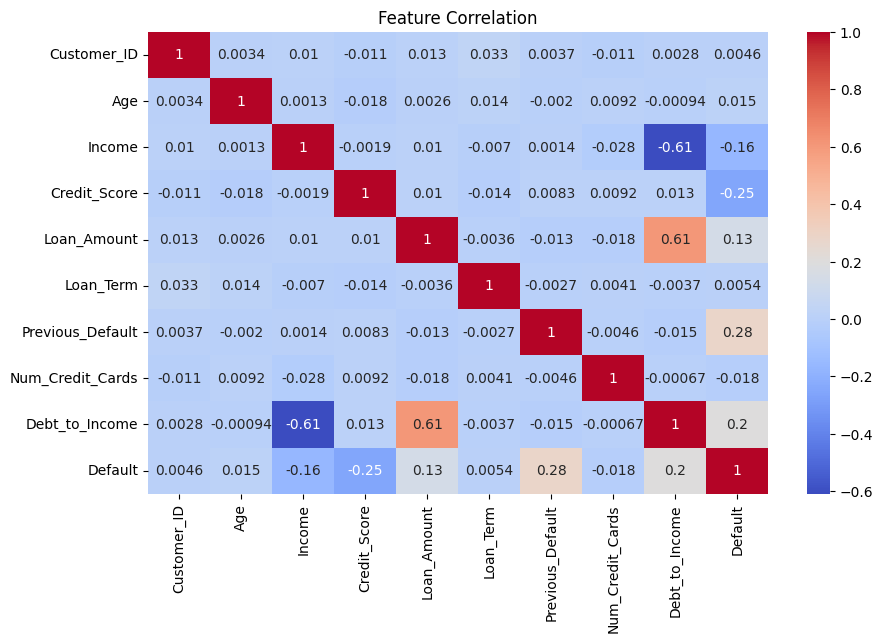

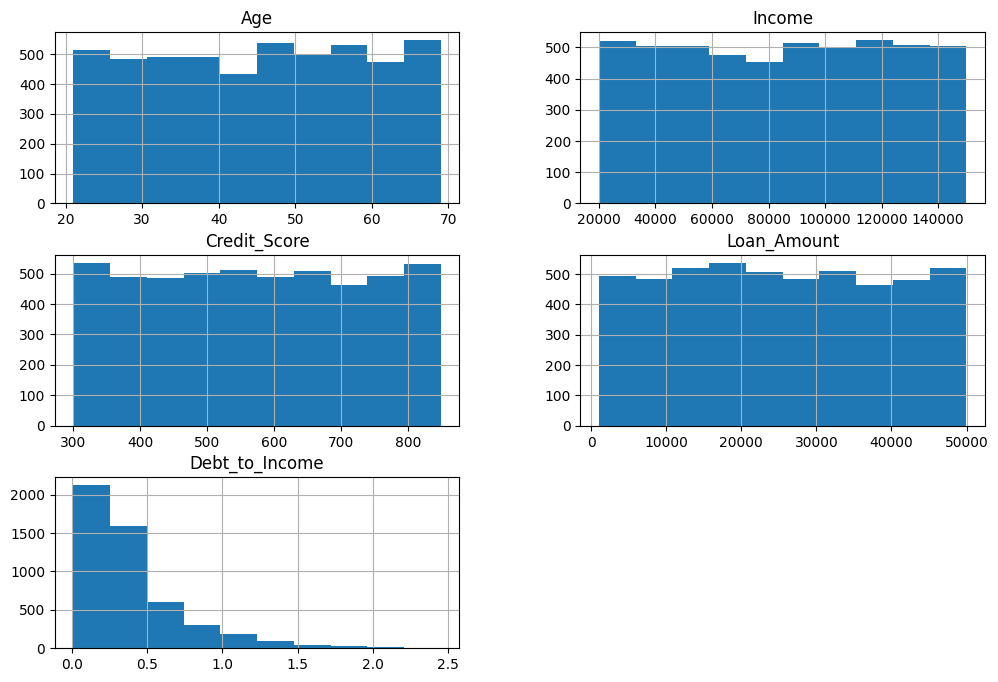

In [14]:
sns.countplot(x='Default', data=data)
plt.title("Default Distribution")
plt.show()

plt.figure(figsize=(10,6))

# Select only numerical columns for correlation matrix
numerical_data = data.select_dtypes(include=np.number)
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

data[['Age','Income','Credit_Score','Loan_Amount','Debt_to_Income']].hist(figsize=(12,8))
plt.show()

**Preprocessing**

In [15]:
# Encode categorical variables
data_encoded = pd.get_dummies(data, columns=['Gender','Employment_Status'], drop_first=True)

# Features and target
X = data_encoded.drop(['Customer_ID','Default'], axis=1)
y = data_encoded['Default']

# Scale numeric features
scaler = StandardScaler()
X[['Age','Income','Credit_Score','Loan_Amount','Debt_to_Income']] = scaler.fit_transform(
    X[['Age','Income','Credit_Score','Loan_Amount','Debt_to_Income']]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_res).value_counts())

Original class distribution:
 Default
0    2825
1    1175
Name: count, dtype: int64
After SMOTE:
 Default
0    2825
1    2825
Name: count, dtype: int64


**Model Training & Evaluation**

In [16]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

# XGBoost
xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.76       706
           1       0.48      0.65      0.55       294

    accuracy                           0.69      1000
   macro avg       0.66      0.68      0.66      1000
weighted avg       0.73      0.69      0.70      1000

ROC-AUC Score: 0.7662263205565513
Random Forest Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       706
           1       0.52      0.59      0.56       294

    accuracy                           0.72      1000
   macro avg       0.67      0.68      0.68      1000
weighted avg       0.73      0.72      0.73      1000

ROC-AUC Score: 0.7770398527683027


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:24:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       706
           1       0.53      0.57      0.55       294

    accuracy                           0.72      1000
   macro avg       0.67      0.68      0.68      1000
weighted avg       0.73      0.72      0.73      1000

ROC-AUC Score: 0.7659517064616215


**Feature Importance (Random Forest)**

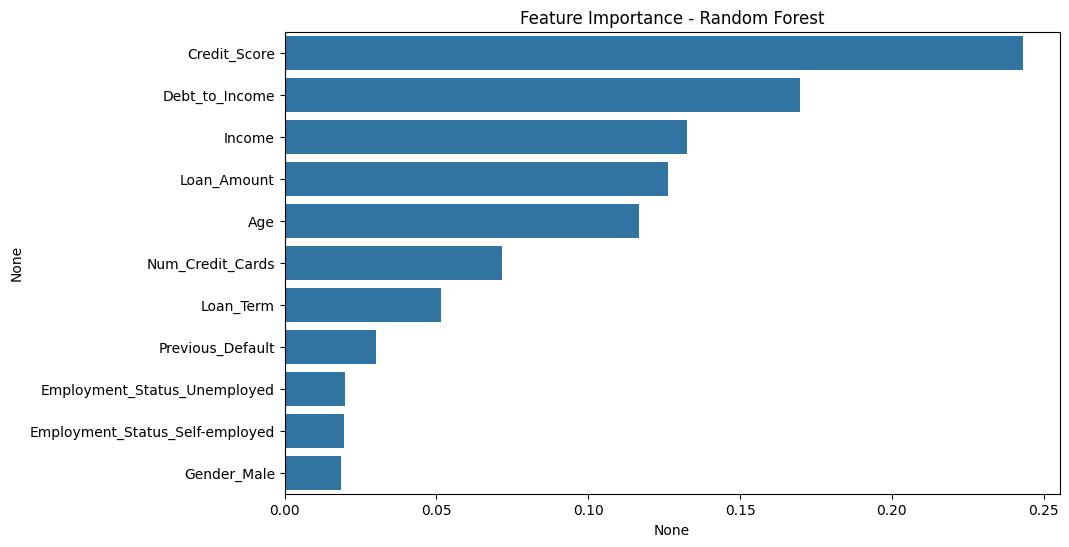

In [17]:
importances = rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - Random Forest")
plt.show()

**Convert PD to Credit Score**

In [18]:
pd_pred = y_proba_xgb
base_score = 600
factor = 50
credit_score_pred = base_score - factor * np.log(pd_pred / (1 - pd_pred))
credit_score_pred = np.clip(credit_score_pred, 300, 850)

# Add to test dataframe
test_results = X_test.copy()
test_results['Predicted_PD'] = pd_pred
test_results['Credit_Score_Pred'] = credit_score_pred
test_results['Predicted_Default'] = y_pred_xgb

**Risk Level Categorization**

In [19]:
def risk_category(score):
    if score >= 800:
        return 'Excellent'
    elif score >= 700:
        return 'Good'
    elif score >= 600:
        return 'Fair'
    else:
        return 'Poor'

test_results['Risk_Level'] = test_results['Credit_Score_Pred'].apply(risk_category)

test_results[['Predicted_PD','Credit_Score_Pred','Predicted_Default','Risk_Level']].head(10)

,Predicted_PD,Credit_Score_Pred,Predicted_Default,Risk_Level
2168,0.994170,343.054840,1,Poor
5,0.018803,797.737732,0,Good
3865,0.010864,825.568481,0,Excellent
2971,0.009230,833.801697,0,Excellent
1357,0.118357,700.404236,0,Good
4311,0.003297,850.000000,0,Excellent
1413,0.051439,745.727295,0,Good
2167,0.249082,655.175781,0,Fair
2351,0.005878,850.000000,0,Excellent
4531,0.400647,620.138428,0,Fair


**Portfolio Risk Report**

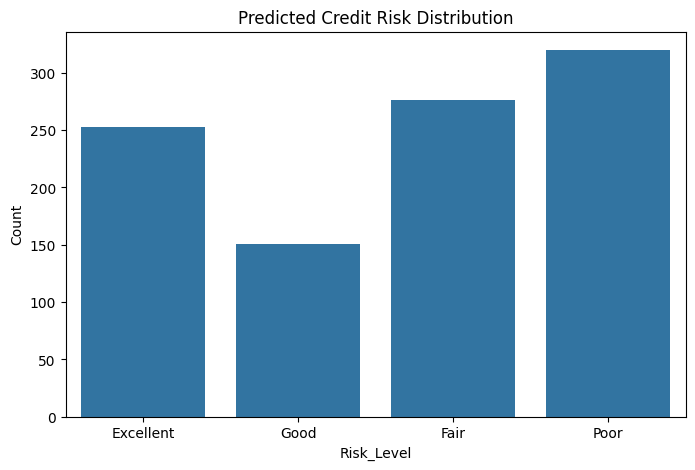

Average Predicted PD by Risk Level:
   Risk_Level  Predicted_PD
0  Excellent      0.004717
1       Fair      0.284376
2       Good      0.059787
3       Poor      0.781756


In [20]:
# Risk distribution
risk_summary = test_results['Risk_Level'].value_counts().reset_index()
risk_summary.columns = ['Risk_Level','Count']

plt.figure(figsize=(8,5))
sns.barplot(x='Risk_Level', y='Count', data=risk_summary, order=['Excellent','Good','Fair','Poor'])
plt.title("Predicted Credit Risk Distribution")
plt.show()

# Average PD per risk level
avg_pd = test_results.groupby('Risk_Level')['Predicted_PD'].mean().reset_index()
print("Average Predicted PD by Risk Level:\n", avg_pd)